In [2]:
"""
# Lasso Regression — NACA 4-Digit Airfoils

**Dataset:** AirfRANS (NACA 4-digit series only — 489 samples)
**Features:** Reynolds number, angle of attack, camber, camber position, thickness
**Target:** Lift-to-Drag ratio (L/D)

Lasso (L1 regularization) performs feature selection by driving some coefficients to exactly zero.
Key hyperparameter: **alpha** (regularization strength)
"""
from __future__ import annotations


from pathlib import Path
import sys


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error


# ─────────────────────────────────────────────────────────────────────────────
# Setup paths
# ─────────────────────────────────────────────────────────────────────────────
def _find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'src').is_dir():
            return p
    raise RuntimeError(f"Could not find repo root from: {start}")


REPO_ROOT = _find_repo_root(Path.cwd())
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))


from src.config import DATA_DIR, RAW_DATASET_DIR
from src.tabular_data import load_airfrans_tabular_split


# ─────────────────────────────────────────────────────────────────────────────
# Load NACA 4-digit dataset
# ─────────────────────────────────────────────────────────────────────────────
csv_path = DATA_DIR / 'airfrans_dataset.csv'
manifest_path = RAW_DATASET_DIR / 'manifest.json'
task = 'full'


train_df, test_df = load_airfrans_tabular_split(csv_path, manifest_path, task=task)

# Clean NACA 4-digit features
feature_cols = ['Reynolds', 'angle_of_attack_rad', 'camber', 'camber_pos', 'thickness']
target_col = 'L_D'

# Descriptive labels for plots
FEATURE_LABELS = {
    'Reynolds': 'Reynolds Number',
    'angle_of_attack_rad': 'Angle of Attack (rad)',
    'camber': 'Max Camber (%)',
    'camber_pos': 'Camber Position (tenths)',
    'thickness': 'Thickness (%)',
}


X_train = train_df[feature_cols]
y_train = np.asarray(train_df[target_col]).reshape(-1)
X_test = test_df[feature_cols]
y_test = np.asarray(test_df[target_col]).reshape(-1)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Features: {feature_cols}")


# ─────────────────────────────────────────────────────────────────────────────
# Preprocessing and evaluation function
# ─────────────────────────────────────────────────────────────────────────────
pre = Pipeline([
    ('scaler', StandardScaler()),
])


def fit_eval(alpha: float) -> dict:
    """Train Lasso with given alpha and return metrics."""
    model = Lasso(alpha=alpha, random_state=42, max_iter=50000)
    pipe = Pipeline([('pre', pre), ('model', model)])
    pipe.fit(X_train, y_train)
    
    y_train_pred = np.asarray(pipe.predict(X_train)).reshape(-1)
    y_test_pred = np.asarray(pipe.predict(X_test)).reshape(-1)
    
    n_train, p = X_train.shape
    n_test = len(y_test)
    
    r2_tr = float(r2_score(y_train, y_train_pred))
    r2_te = float(r2_score(y_test, y_test_pred))
    
    # Adjusted R²
    r2_adj_tr = 1 - (1 - r2_tr) * (n_train - 1) / (n_train - p - 1)
    r2_adj_te = 1 - (1 - r2_te) * (n_test - 1) / (n_test - p - 1)
    
    rmse_te = float(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    coef = np.asarray(pipe.named_steps['model'].coef_)
    nnz = int(np.sum(np.abs(coef) > 1e-12))
    
    return {
        'alpha': alpha,
        'r2_train': r2_tr,
        'r2_test': r2_te,
        'r2_adj_train': r2_adj_tr,
        'r2_adj_test': r2_adj_te,
        'rmse_test': rmse_te,
        'nonzero_coef': nnz,
        'coef': coef,
    }

Training samples: 378, Test samples: 111
Features: ['Reynolds', 'angle_of_attack_rad', 'camber', 'camber_pos', 'thickness']


In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# Alpha Sweep
# ─────────────────────────────────────────────────────────────────────────────
alphas = np.logspace(-4, 2, 30)
rows = [fit_eval(float(a)) for a in alphas]
res = pd.DataFrame(rows)

# Best result
best = res.loc[res['r2_adj_test'].idxmax()]
print(f"\nBest alpha = {best['alpha']:.2e}")
print(f"  Train R² adj = {best['r2_adj_train']:.4f}")
print(f"  Test R² adj  = {best['r2_adj_test']:.4f}")
print(f"  RMSE (test)  = {best['rmse_test']:.2f}")
print(f"  Non-zero coefficients: {int(best['nonzero_coef'])}/{len(feature_cols)}")

res[['alpha', 'r2_adj_train', 'r2_adj_test', 'rmse_test', 'nonzero_coef']].sort_values('r2_adj_test', ascending=False).head(10)


Best alpha = 8.53e-01
  Train R² adj = 0.6660
  Test R² adj  = 0.5877
  RMSE (test)  = 21.21
  Non-zero coefficients: 5/5


,alpha,r2_adj_train,r2_adj_test,rmse_test,nonzero_coef
19,0.853168,0.665974,0.587711,21.207021,5
18,0.529832,0.667597,0.587155,21.221314,5
20,1.373824,0.661768,0.586788,21.230726,5
17,0.329034,0.668222,0.586374,21.241364,5
16,0.204336,0.668464,0.585722,21.258114,5
15,0.126896,0.668557,0.585252,21.270169,5
14,0.078805,0.668593,0.584935,21.278292,5
13,0.048939,0.668606,0.584728,21.283582,5
12,0.030392,0.668612,0.584597,21.286961,5
11,0.018874,0.668614,0.584513,21.289096,5


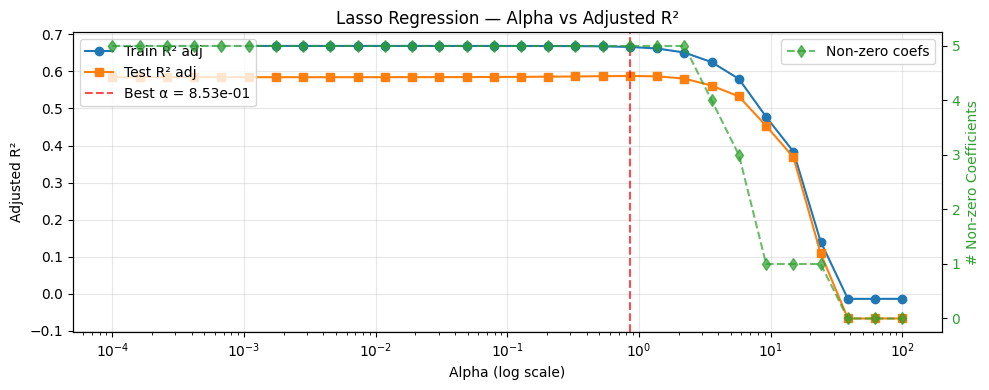


Observation: As alpha increases, L1 penalty drives coefficients to zero (feature selection).


In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot 1: Alpha vs R² Adjusted
# ─────────────────────────────────────────────────────────────────────────────
fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.semilogx(res['alpha'], res['r2_adj_train'], 'o-', label='Train R² adj', color='tab:blue')
ax1.semilogx(res['alpha'], res['r2_adj_test'], 's-', label='Test R² adj', color='tab:orange')
ax1.axvline(best['alpha'], color='red', linestyle='--', alpha=0.7, label=f"Best α = {best['alpha']:.2e}")
ax1.set_xlabel('Alpha (log scale)')
ax1.set_ylabel('Adjusted R²')
ax1.set_title('Lasso Regression — Alpha vs Adjusted R²')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Secondary axis for non-zero coefficients
ax2 = ax1.twinx()
ax2.semilogx(res['alpha'], res['nonzero_coef'], 'd--', color='tab:green', alpha=0.7, label='Non-zero coefs')
ax2.set_ylabel('# Non-zero Coefficients', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"\nObservation: As alpha increases, L1 penalty drives coefficients to zero (feature selection).")

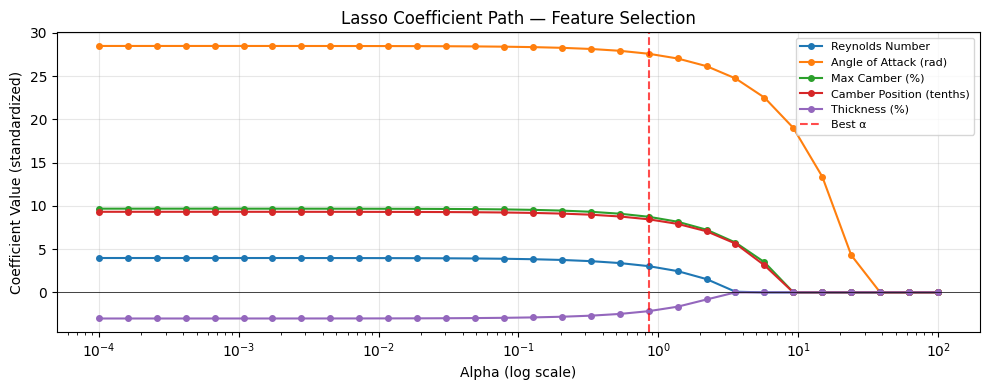


Coefficients at best alpha:
  Reynolds Number               : +3.0341 ✓
  Angle of Attack (rad)         : +27.5993 ✓
  Max Camber (%)                : +8.7442 ✓
  Camber Position (tenths)      : +8.4510 ✓
  Thickness (%)                 : -2.1729 ✓


In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot 2: Coefficient Path (how coefficients shrink with alpha)
# ─────────────────────────────────────────────────────────────────────────────
coef_matrix = np.array([r['coef'] for r in rows])

fig, ax = plt.subplots(figsize=(10, 4))
for i, feat in enumerate(feature_cols):
    ax.semilogx(res['alpha'], coef_matrix[:, i], 'o-', label=FEATURE_LABELS.get(feat, feat), markersize=4)

ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(best['alpha'], color='red', linestyle='--', alpha=0.7, label=f"Best α")
ax.set_xlabel('Alpha (log scale)')
ax.set_ylabel('Coefficient Value (standardized)')
ax.set_title('Lasso Coefficient Path — Feature Selection')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Which features survive at best alpha?
best_coef = best['coef']
print("\nCoefficients at best alpha:")
for feat, c in zip(feature_cols, best_coef):
    status = "✓" if abs(c) > 1e-12 else "✗ (eliminated)"
    print(f"  {FEATURE_LABELS.get(feat, feat):30s}: {c:+.4f} {status}")

---

## Conclusions (Lasso Only)

### Final Lasso Metrics (Best Observed)
- **Best alpha (sweep):** `alpha=0.853168`
- **Adjusted $R^2$ (train):** $0.665974$
- **Adjusted $R^2$ (test):** $0.587711$
- **Test RMSE:** $21.207021$
- **Non-zero coefficients:** $5/5$

### Key Deductions
1. **Lasso does not materially improve generalization here.** The best test $R^2_{adj}$ is in the same band as other linear models, indicating the dominant limitation is linear model bias (nonlinear physics) rather than overfitting.
2. **No feature selection occurs at the optimum.** At the best alpha, Lasso keeps **all 5 coefficients non-zero**, so the L1 penalty is not producing a sparse model for this dataset/feature set.
3. **The solution is relatively insensitive across a wide alpha range.** Many alphas near the optimum yield very similar test $R^2_{adj}$, reinforcing that tuning regularization cannot fix model misspecification.